In [1]:
#!nvidia-smi

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchsummary import summary

from DatasetLogReturn import StockDatasetLogReturn
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

import math
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt

In [3]:
configs = {
    "batch_size" : 128,
    "max_file_count" : 2179,
    "train_file" : 10,
    "validation_file" : 5,
    "test_file" : 5,
    "input_size" : 8,
    "output_size" : 1,
    "init_learning_rate" : 3e-4,
    "scheduler_factor": 0.8,
    "scheduler_patience": 3,
    "scheduler_min_lr": 2e-5,
    "epoch" : 30,
    "model_name" : "GRU1",
}

configs["file_count"] = configs["train_file"] + configs["validation_file"] + configs["test_file"]
configs["model_folder"] = f"./models/{configs["model_name"]}/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
tickers = list(map(str.strip,open("tickers_sp500.txt","r").readlines()))
filenames = ["./data/" + x + ".csv" for x in tickers]
rd.shuffle(filenames)
filenames = filenames[:configs["file_count"]]

train_files, test_files = train_test_split(filenames,test_size=configs["test_file"]/configs["file_count"])
train_files, val_files = train_test_split(train_files,test_size=configs["validation_file"]/(configs["train_file"] + configs["validation_file"]))

train_dataset = StockDatasetLogReturn(train_files, configs["input_size"], configs["output_size"])
train_dataset.Preprocess()
train_loader = DataLoader(train_dataset,batch_size=configs["batch_size"],shuffle=True)

val_dataset = StockDatasetLogReturn(val_files,configs["input_size"],configs["output_size"])
val_dataset.Preprocess()
val_loader = DataLoader(val_dataset,batch_size=configs["batch_size"],shuffle=True)

test_dataset = StockDatasetLogReturn(test_files,configs["input_size"],configs["output_size"])
test_dataset.Preprocess()
test_loader = DataLoader(test_dataset,batch_size=configs["batch_size"],shuffle=True)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/86694 [00:00<?, ?it/s]

d:\Programming\Pattern_Reg_Final\DatasetLogReturn.py:48: RuntimeWarning: divide by zero encountered in log
  c = np.log(b)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/48052 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/48618 [00:00<?, ?it/s]

In [6]:
torch.set_default_dtype(torch.float32)
class StockGRU(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.hidden_size = 512
        self.batch_size = configs["batch_size"]
        self.layer1 = nn.GRU(1,self.hidden_size,2,batch_first=True,bias=False)
        self.layer2 = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.LayerNorm(self.hidden_size),
            nn.Linear(self.hidden_size,1,bias=False),
        )
        self.data_scaler = 25

    def forward(self, input) :
        input = torch.multiply(input,self.data_scaler)

        h1,(hn,cn) = self.layer1(input)
        output = self.layer2(h1[:,-1,:])

        output = torch.divide(output,self.data_scaler)
        return output


In [10]:
model = StockGRU()
model = model.to(device)

print(summary(model,input_size=(configs["batch_size"],configs["input_size"],1)))

Layer (type:depth-idx)                   Param #
├─GRU: 1-1                               2,360,832
├─Sequential: 1-2                        --
|    └─Dropout: 2-1                      --
|    └─LayerNorm: 2-2                    1,024
|    └─Linear: 2-3                       512
Total params: 2,362,368
Trainable params: 2,362,368
Non-trainable params: 0
Layer (type:depth-idx)                   Param #
├─GRU: 1-1                               2,360,832
├─Sequential: 1-2                        --
|    └─Dropout: 2-1                      --
|    └─LayerNorm: 2-2                    1,024
|    └─Linear: 2-3                       512
Total params: 2,362,368
Trainable params: 2,362,368
Non-trainable params: 0


In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr = configs["init_learning_rate"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=configs['scheduler_factor'],
    patience=configs['scheduler_patience'],
    min_lr=configs['scheduler_min_lr']
)
loss_fn = torch.nn.MSELoss()

In [9]:
train_losses = []
val_losses = []
avarage_train_losses = []
avarage_val_losses = []
learning_rates = []

model_folder = configs["model_folder"]
best_loss = 1000000

for epoch in tqdm(range(configs["epoch"])) :

    model.train()

    learning_rates.append(optimizer.param_groups[0]['lr'])

    cur_train_loss = []
    for input,target in tqdm(train_loader) :

        close_price_input = input[:,4,:,None]
        close_price_target = target[:,4,:]
        close_price_input = close_price_input.to(device)
        close_price_target = close_price_target.to(device)

        if(close_price_input.shape[0] != configs["batch_size"]) :
            continue

        optimizer.zero_grad()

        output = model(close_price_input)

        loss = loss_fn(output,close_price_target)

        loss.backward()

        optimizer.step()

        train_losses.append(loss.to(torch.device("cpu")).item())
        cur_train_loss.append(loss.to(torch.device("cpu")).item())

    avarage_train_loss = np.mean(np.array(cur_train_loss))
    avarage_train_losses.append(avarage_train_loss)

    model.eval()

    with torch.no_grad() :
        cur_val_loss = []
        for input,target in tqdm(val_loader) :

            close_price_input = input[:,4,:,None]
            close_price_target = target[:,4,:]
            close_price_input = close_price_input.to(device)
            close_price_target = close_price_target.to(device)

            if(close_price_input.shape[0] != configs["batch_size"]) :
                continue

            output = model(close_price_input)

            loss = loss_fn(output,close_price_target)

            val_losses.append(loss.to(torch.device("cpu")).item())
            cur_val_loss.append(loss.to(torch.device("cpu")).item())

        avarage_val_loss = np.mean(np.array(cur_val_loss))
        avarage_val_losses.append(avarage_val_loss)

        scheduler.step(avarage_val_loss)
        
        if(best_loss > avarage_val_loss) :

            state = {
                'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avarage_train_loss,
                'val_loss': avarage_val_loss,
                'best_val_loss': best_loss,
            }

            best_loss = avarage_val_loss

            torch.save(state, model_folder + "GRU.pth.tar")

    print("train loss : ",avarage_train_loss)
    print("val loss : ",avarage_val_loss)


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

train loss :  0.00046303581720532483
val loss :  0.0003969036685035548


  0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

train loss :  0.0004354848899875908
val loss :  0.000403941796516476


  0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

train loss :  0.00043251388349724225
val loss :  0.0003905263025842731


  0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

train loss :  0.00043112472833769047
val loss :  0.00039028393397209644


  0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

train loss :  0.0004298402916829425
val loss :  0.0003894629634421143


  0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

train loss :  0.0004289250592563495
val loss :  0.00038944065101547646


  0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

train loss :  0.000428857206950857
val loss :  0.00039212566958050856


  0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

train loss :  0.000428720868626766
val loss :  0.00038907402422371054


  0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

train loss :  0.00042825628990245096
val loss :  0.00038878734003329777


  0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

train loss :  0.0004284145112598495
val loss :  0.0003893568956874243


  0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

train loss :  0.00042826783999802673
val loss :  0.00039011741512581956


  0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

train loss :  0.00042828339079237064
val loss :  0.00038845289611360537


  0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

train loss :  0.00042804193502956033
val loss :  0.0003890398125460995


  0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

train loss :  0.000428169498673144
val loss :  0.00038874474142492217


  0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

train loss :  0.0004280029804231214
val loss :  0.0003889815013042787


  0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

train loss :  0.0004279756190290441
val loss :  0.00038900681195631746


  0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

train loss :  0.000427756473300826
val loss :  0.0003886923946571624


  0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

train loss :  0.0004272413390671683
val loss :  0.00038878187413408336


  0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

train loss :  0.0004274393504187319
val loss :  0.0003899851069266532


  0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

train loss :  0.00042747918052394527
val loss :  0.00038997968652559434


  0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

train loss :  0.00042748572196223724
val loss :  0.00038851864719383674


  0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

train loss :  0.0004275602632151795
val loss :  0.000388514143095028


  0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

train loss :  0.00042747432491052205
val loss :  0.0003886855402991351


  0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

train loss :  0.00042756877728788306
val loss :  0.00038866985536429254


  0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

train loss :  0.00042733090469581166
val loss :  0.00038831596789994506


  0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

train loss :  0.00042744896956636543
val loss :  0.00038849927359830205


  0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

train loss :  0.00042732203424628956
val loss :  0.00038799092764021877


  0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

train loss :  0.00042732984315225207
val loss :  0.00038919607247950413


  0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

train loss :  0.0004273204136770179
val loss :  0.0003889895290275736


  0%|          | 0/703 [00:00<?, ?it/s]

  0%|          | 0/467 [00:00<?, ?it/s]

train loss :  0.00042741352392004355
val loss :  0.00038876085673421903


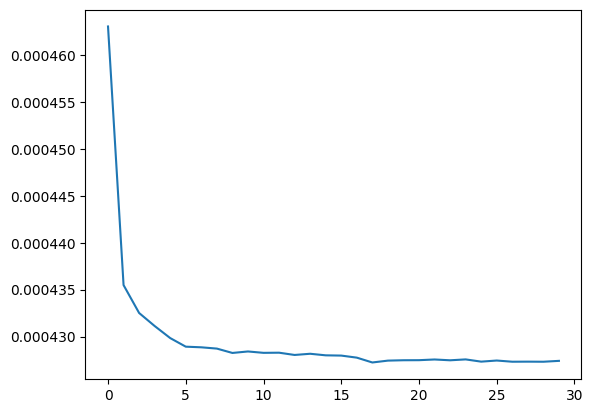

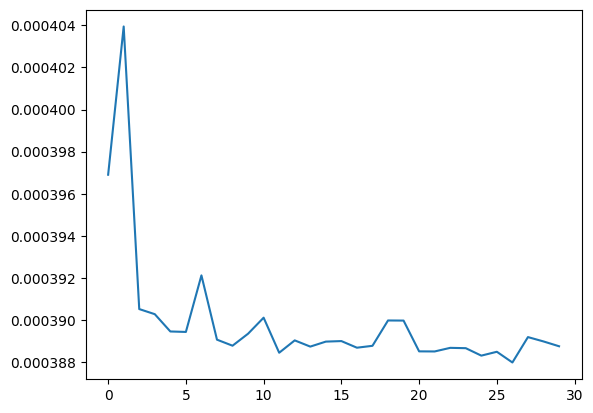

In [10]:
plt.plot(avarage_train_losses)
plt.show()
plt.plot(avarage_val_losses)
plt.show()

In [11]:
train_losses_file = open(configs["model_folder"] + "train_losses.txt",'w')
val_losses_file = open(configs["model_folder"] + "val_losses.txt","w")

for value in train_losses :
    train_losses_file.write(f"{value}\n")

for value in val_losses :
    val_losses_file.write(f"{value}\n")

train_losses_file.close()
val_losses_file.close()

In [36]:
best_model = StockGRU()
# best_model.load_state_dict(torch.load(configs["model_folder"] + "GRU.pth.tar")['model'])

best_model.to(device)
best_model.eval()    

StockGRU(
  (layer1): GRU(1, 512, num_layers=2, bias=False, batch_first=True)
  (layer2): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=512, out_features=1, bias=False)
  )
)

In [13]:
with torch.no_grad() :
    cur_test_loss = []
    for input,target in tqdm(test_loader) :

        close_price_input = input[:,4,:,None]
        close_price_target = target[:,4,:]
        close_price_input = close_price_input.to(device)
        close_price_target = close_price_target.to(device)

        if(close_price_input.shape[0] != configs["batch_size"]) :
            continue

        output = best_model(close_price_input)

        loss = loss_fn(output,close_price_target)

        cur_test_loss.append(loss.to(torch.device("cpu")).item())

    avarage_test_loss = np.mean(np.array(cur_test_loss))

print(avarage_test_loss)

  0%|          | 0/380 [00:00<?, ?it/s]

0.0004087372448468596


In [14]:
def get_log_stock_prediction(model, stock_files) :
    model.eval()
    data_set = StockDatasetLogReturn(stock_files, configs["input_size"], 1)
    data_set.Preprocess()
    data_loader = DataLoader(data_set,configs["batch_size"])
    predict_res = []
    target_res = []
    
    with torch.no_grad() : 
        
        for input,target in tqdm(data_loader) :
            close_price_input = input[:,4,:,None]
            close_price_target = target[:,4,:]
            close_price_input = close_price_input.to(device)

            output = model(close_price_input)

            close_price_input = close_price_input.to(torch.device("cpu"))
            
            predict_res += output.to(torch.device("cpu")).reshape(-1).tolist()
            target_res += close_price_target.to(torch.device("cpu")).reshape(-1).tolist()

    return np.array(predict_res),np.array(target_res)


In [30]:
def trade_test(predict, real) :
    buy_pos = predict > 0
    total_profit = np.exp(np.sum(buy_pos * real))
    return total_profit

In [37]:
predict,target = get_log_stock_prediction(best_model, ["./data/A.csv"])


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6129 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

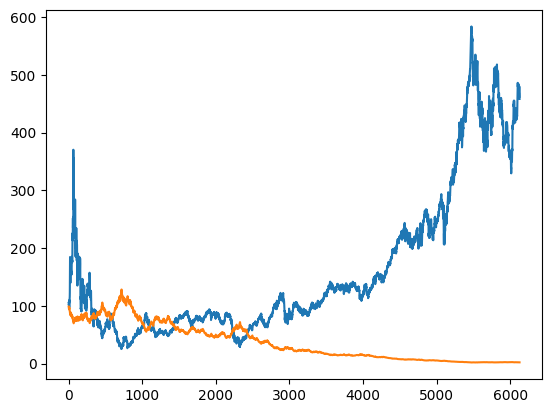

In [38]:
predict_percent = np.exp(predict)
target_percent = np.exp(target)
predict_plot = np.cumprod(predict_percent) * 100
target_plot = np.cumprod(target_percent) * 100
plt.plot(target_plot)
plt.plot(predict_plot)
plt.show()

In [50]:
total_profit = trade_test(predict,target)
print("total_profit : ",total_profit)
buy_and_hold_profit = trade_test(np.ones(target.shape),target)
print("buy and hold : ",buy_and_hold_profit)
random_profit = trade_test(np.random.randint(low=0,high=2,size=target.shape),target)
print("random profit : ",random_profit)

total_profit :  1.2776576053056505
buy and hold :  4.5820224637360205
random profit :  6.619058530039797


[]

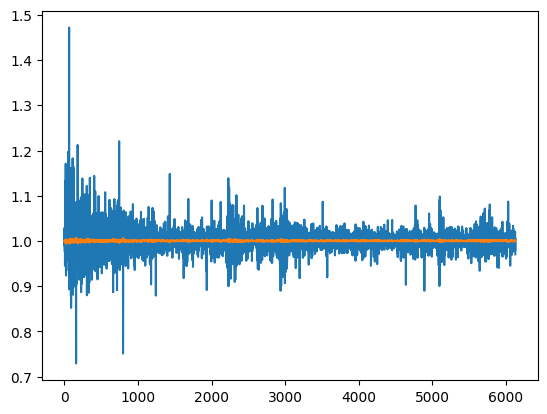

In [33]:
plt.plot(target_percent)
plt.plot(predict_percent)
plt.plot()

In [34]:
print(np.mean((np.log(np.array(target_percent)) * np.log(np.array(predict_percent))) > 0))

0.5041605482134116


In [35]:
plt.plot(learning_rates)
plt.show()

NameError: name 'learning_rates' is not defined